### SuperSpike 

This tutorial implements the SuperSpike learning rule with a simple network prototype with one pre-synaptic neuron and one post-synaptic neuron. The Lava Process Architecture is as shown below:

![SuperSpike_Architecture](SuperSpike_architecture.svg)

In [1]:
import numpy as np
import time as timing

from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer as SpikeIn
from lava.magma.core.learning.learning_rule import LoihiLearningRule
from lava.proc.dense.process import LearningDense, Dense
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

#### Importing the SuperSpike Learning Rule Wrapper

![SuperSpike](SuperSpike_learning_rule.svg)

In [2]:
from lava.proc.learning_rules.SuperSpike_learning_rule import DoubleExponentialSuperSpikeLoihi

SuperSpike = DoubleExponentialSuperSpikeLoihi(learning_rate=0.05,
                                              pre_synaptic_decay_tau=10,
                                              pre_synaptic_rise_tau=5,
                                              eligibility_trace_decay_tau=0.5,
                                              eligibility_trace_rise_tau=0.4,
                                              t_epoch=1
                                              )

#### Setting Simulation Parameters and Creating Input Spikes

In [3]:
SELECT_TAG = "floating_pt"

In [4]:
# ============================================================================================================
# PARAMS
# ============================================================================================================
# General Params
num_rounds = 20
num_steps_single_presentation = 500
num_steps = num_rounds * num_steps_single_presentation

# Neural Params
num_neurons_pre = 1
shape_lif_pre = (num_neurons_pre, )
du_pre = 1
dv_pre = 1
vth_pre = 0.99

num_neurons_post = 1
shape_lif_post = (num_neurons_post, )
du_post = 0.3
dv_post = 0.6
vth_post = 1

wgt_input_pre = np.eye(num_neurons_pre) * 1

shape_pre_post = shape_lif_post + shape_lif_pre
wgt_pre_post = np.full(shape_pre_post, 1)

wgt_reward_post = np.eye(num_neurons_post) * 1

np.random.seed(1523)
spike_prob = 0.03
spike_raster_pre = np.zeros((num_neurons_pre, num_steps_single_presentation), dtype=int)
np.place(spike_raster_pre, np.random.rand(num_neurons_pre, num_steps_single_presentation) < spike_prob, 1)

spike_times_post_target = [150]
spikes_raster_post_target = np.zeros((num_neurons_post, num_steps_single_presentation), dtype=int)
spikes_raster_post_target[0, spike_times_post_target] = 1
# ============================================================================================================
# ============================================================================================================

#### Creating a LearningDenseProbe for Measuring Trace Dynamics

_NOTE : This is workaround for simulation taking too long while using Monitor's_

In [5]:
from utils_SuperSpike import LearningDenseProbe, PyLearningDenseProbeModelFloat, SuperSpikeLIF, PySuperSpikeLifModelFloat

#### Lava Process Architecture

One pre-synaptic neuron is connected to one post-synaptic neuron. One plastic synapse is update via the 'SuperSpike' learning rule.

In [6]:
# Create input devices
pattern_pre = SpikeIn(data=spike_raster_pre)

# Create error signal input device
reward_pattern_post = SpikeIn(data=spikes_raster_post_target)

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_input_pre)
conn_inp_reward = Dense(weights=wgt_reward_post)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du_pre,
              dv=dv_pre,
              bias_mant=0,
              bias_exp=0,
              vth=vth_pre,
              shape=shape_lif_pre,
              name='lif_pre')

# Create plastic connection
plast_conn = LearningDenseProbe(weights=wgt_pre_post,
                   learning_rule=SuperSpike,
                   name='plastic_dense')

# Create post-synaptic neuron
lif_post = SuperSpikeLIF(u=0,
               v=0,
               du=du_post,
               dv=dv_post,
               bias_mant=0,
               bias_exp=0,
               vth=vth_post,
               shape=shape_lif_post,
               learning_rule=SuperSpike,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

# Reward ports
reward_pattern_post.s_out.connect(conn_inp_reward.s_in)
conn_inp_reward.a_out.connect(lif_post.a_third_factor_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating action potential (BAP)
lif_post.s_out_bap.connect(plast_conn.s_in_bap)

# Connect reward trace callback (y2, y3)
lif_post.s_out_y1.connect(plast_conn.s_in_y1)
lif_post.s_out_y2.connect(plast_conn.s_in_y2)
lif_post.s_out_y3.connect(plast_conn.s_in_y3)

#### Custom Monitor Process and ProcessModel to Measure Trace State.

In [7]:
from utils_SuperSpike import MyMonitor, MyMonitorPM

In [8]:
monitor = MyMonitor(shape_pre=shape_lif_pre, 
                    shape_post=shape_lif_post, 
                    shape_learning_dense=shape_lif_post+shape_lif_pre, 
                    buffer_size=num_steps)

lif_pre.s_out.connect(monitor.pre_spikes_port)
lif_post.s_out.connect(monitor.post_spikes_port)

plast_conn.x1_port.connect(monitor.learning_dense_x1_port)
plast_conn.x2_port.connect(monitor.learning_dense_x2_port)
plast_conn.y2_port.connect(monitor.learning_dense_y2_port)
plast_conn.y3_port.connect(monitor.learning_dense_y3_port)
plast_conn.weights_port.connect(monitor.learning_dense_weights_port)
plast_conn.tag_1_port.connect(monitor.learning_dense_tag_1_port)
plast_conn.tag_2_port.connect(monitor.learning_dense_tag_2_port)

In [9]:
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))

In [10]:
# Get data from monitors
pre_spikes = monitor.pre_spikes.get()[0][:, np.newaxis]
post_spikes = monitor.post_spikes.get()[0][:, np.newaxis]

pre_trace_decay = monitor.learning_dense_x1.get()[0][:, np.newaxis]
pre_trace_rise = monitor.learning_dense_x2.get()[0][:, np.newaxis]
y2_ = monitor.learning_dense_y2.get()[0][:, np.newaxis]
y3_ = monitor.learning_dense_y3.get()[0][:, np.newaxis]
weights = monitor.learning_dense_weights.get()[0, 0][:, np.newaxis]
tag = monitor.learning_dense_tag_1.get()[0, 0][:, np.newaxis]
delay = monitor.learning_dense_tag_2.get()[0, 0][:, np.newaxis]

In [11]:
pattern_pre.stop()

#### Results and Plotting

In [12]:
from utils_SuperSpike import plot_spikes, plot_time_series, plot_time_series_combo

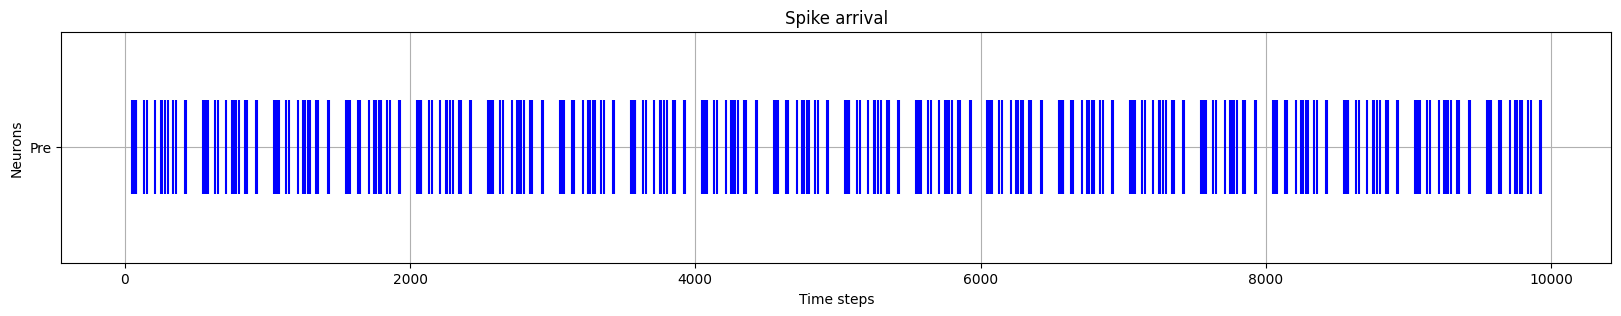

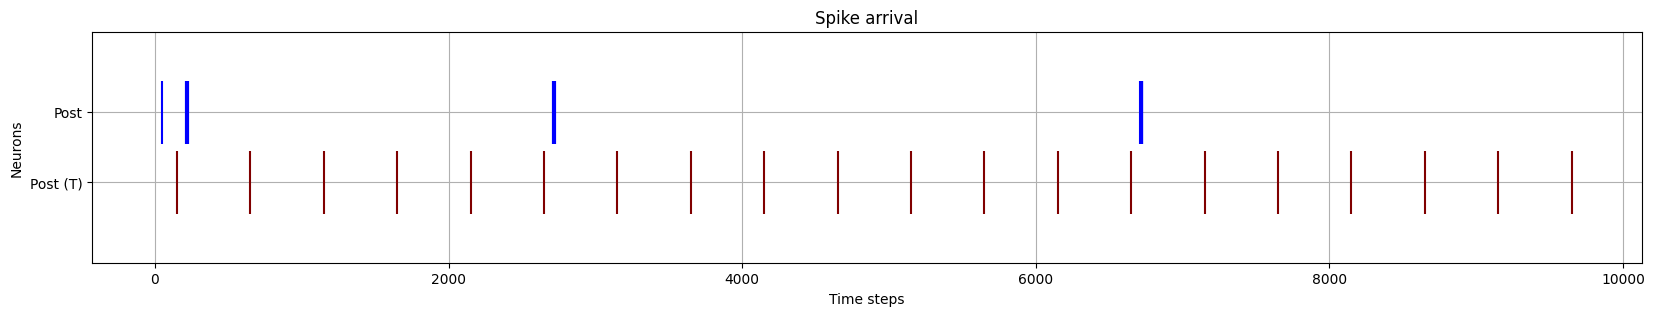

In [13]:
time = range(1, num_steps +1 )

# Plot spikes
plot_spikes(spikes=[np.where(pre_spikes[:, 0])[0]], 
            legend=['Pre'], 
            colors=['blue'])

# Plot spikes
plot_spikes(spikes=[np.where(np.tile(spikes_raster_post_target[0], num_rounds))[0], np.where(post_spikes[:, 0])[0]], 
            legend=['Post (T)', 'Post'], 
            colors=["maroon", 'blue'])

X1 Trace superimposed with pre-spikes


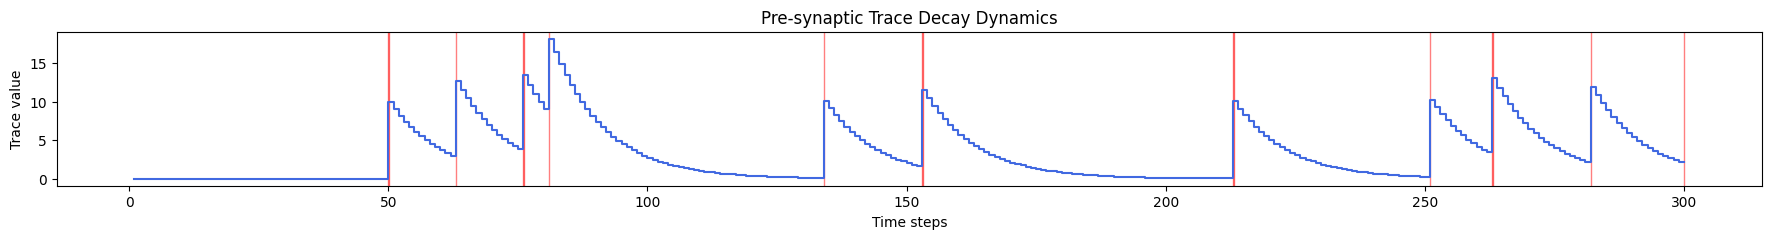

X2 Trace superimposed with pre-spikes


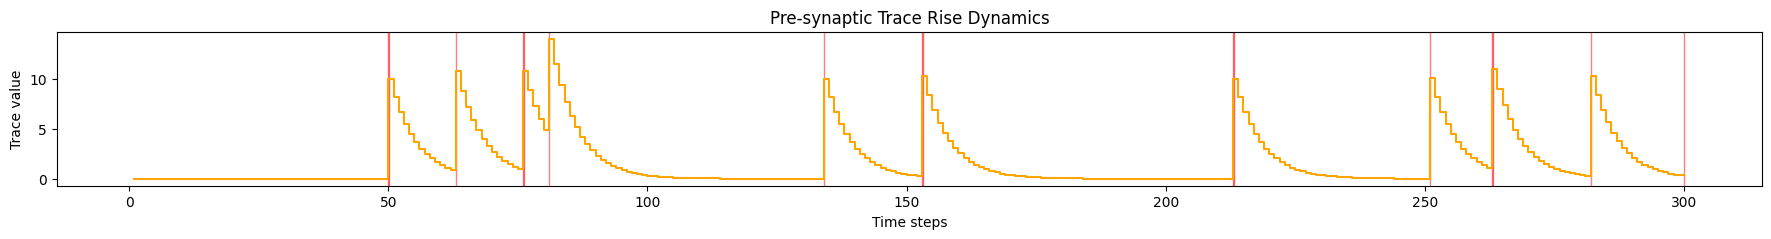

Difference of Exponential (x1-x2)


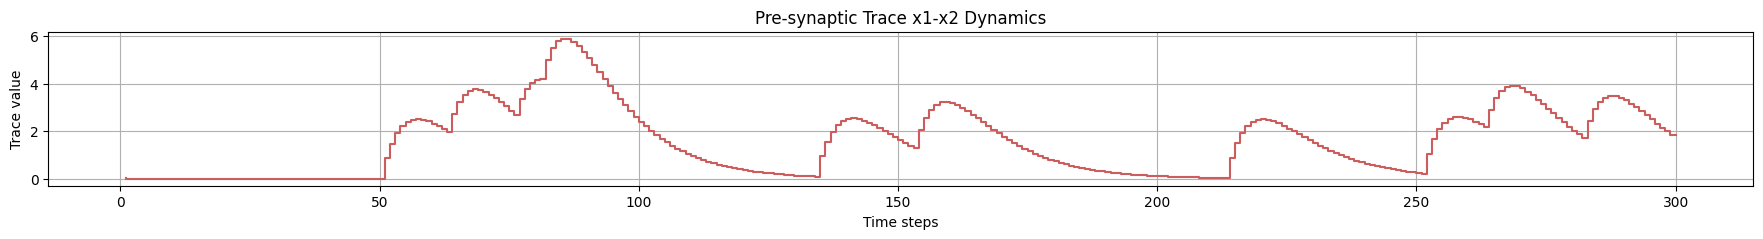

Error Trace superimposed with post-spikes


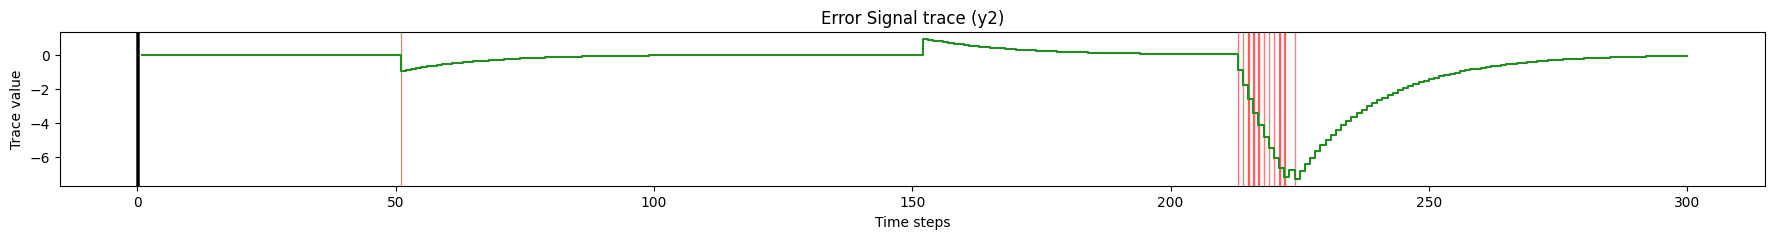

In [17]:
print("X1 Trace superimposed with pre-spikes")
plot_time_series_combo(time=time[0:300], 
                       time_series=pre_trace_decay[0:300], 
                       ylabel="Trace value", 
                       title="Pre-synaptic Trace Decay Dynamics", 
                       figsize=(22, 2), 
                       colors=['royalblue', 'red'],
                       spikes=np.where(pre_spikes[0:300, 0])[0]+1
                       )

print("X2 Trace superimposed with pre-spikes")
plot_time_series_combo(time=time[0:300], 
                       time_series=pre_trace_rise[0:300], 
                       ylabel="Trace value", 
                       title="Pre-synaptic Trace Rise Dynamics", 
                       figsize=(22, 2), 
                       colors=['orange','red'],
                       spikes=np.where(pre_spikes[0:300, 0])[0]+1
                       )

print("Difference of Exponential (x1-x2)")
x1_minus_x2 = pre_trace_decay - pre_trace_rise
plot_time_series(time=time[0:300], 
                 time_series=x1_minus_x2[0:300], 
                 ylabel="Trace value", 
                 title="Pre-synaptic Trace x1-x2 Dynamics", 
                 figsize=(22, 2), 
                 color='indianred')

print("Error Trace superimposed with post-spikes")
plot_time_series_combo(time=time[0:300], 
                       time_series=y2_[0:300], 
                       ylabel="Trace value", 
                       title="Error Signal trace (y2)", 
                       figsize=(22, 2), 
                       colors=['forestgreen','red', 'black'],
                       spikes=np.where(post_spikes[0:300, 0])[0],
                       spikes_target=np.where(np.tile(spikes_raster_post_target[0:300], num_rounds))[0],
                       target=True
                       )

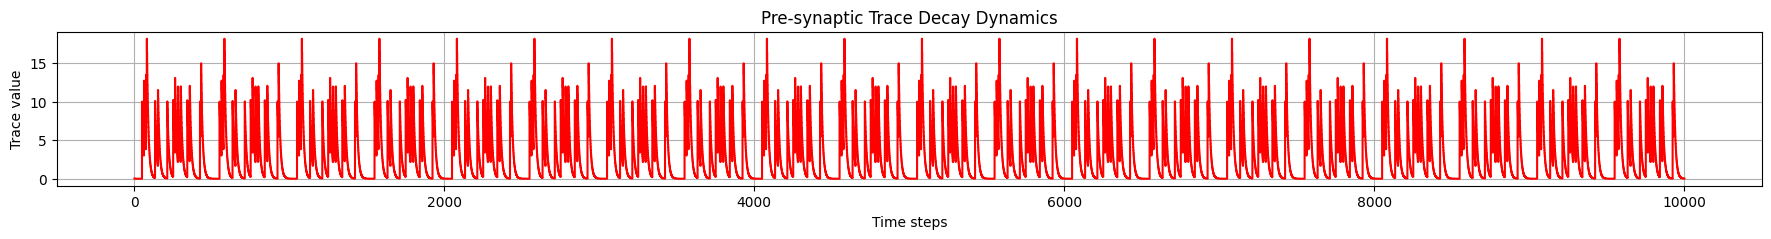

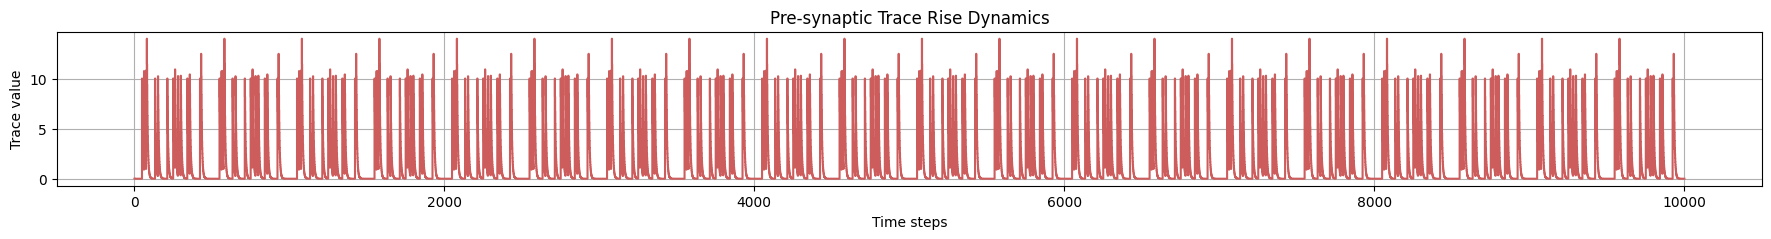

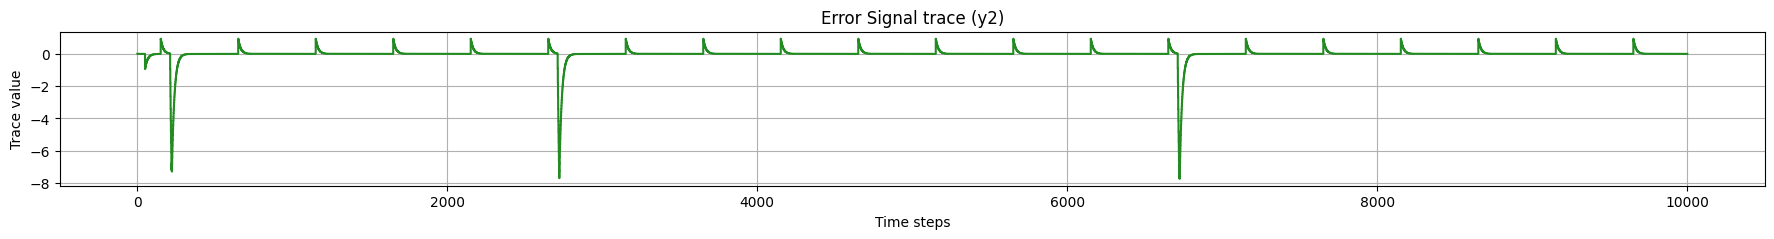

In [15]:
plot_time_series(time=time, 
                 time_series=pre_trace_decay, 
                 ylabel="Trace value", 
                 title="Pre-synaptic Trace Decay Dynamics", 
                 figsize=(22, 2), 
                 color='red')

plot_time_series(time=time, 
                 time_series=pre_trace_rise, 
                 ylabel="Trace value", 
                 title="Pre-synaptic Trace Rise Dynamics", 
                 figsize=(22, 2), 
                 color='indianred')

plot_time_series(time=time, 
                 time_series=y2_, 
                 ylabel="Trace value", 
                 title="Error Signal trace (y2)", 
                 figsize=(22, 2), 
                 color='forestgreen')


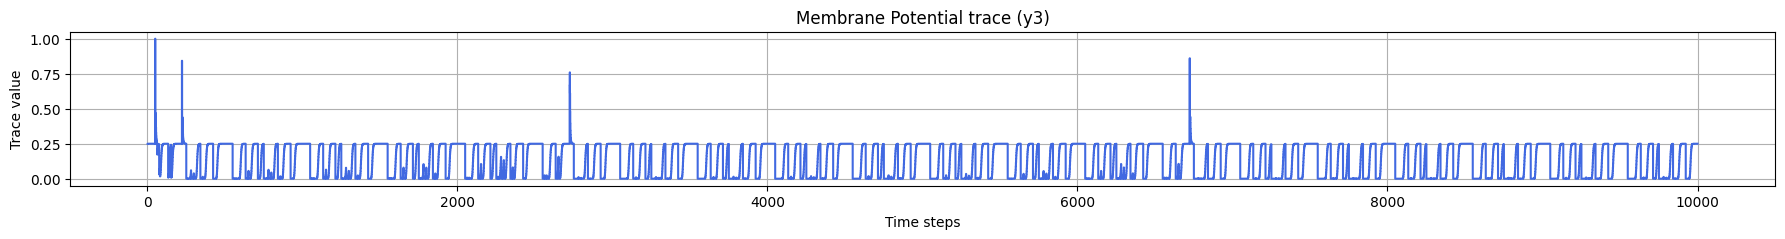

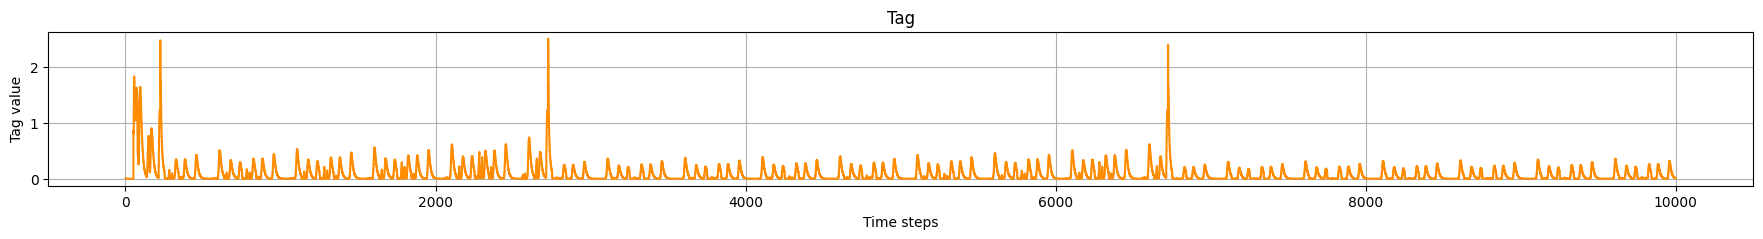

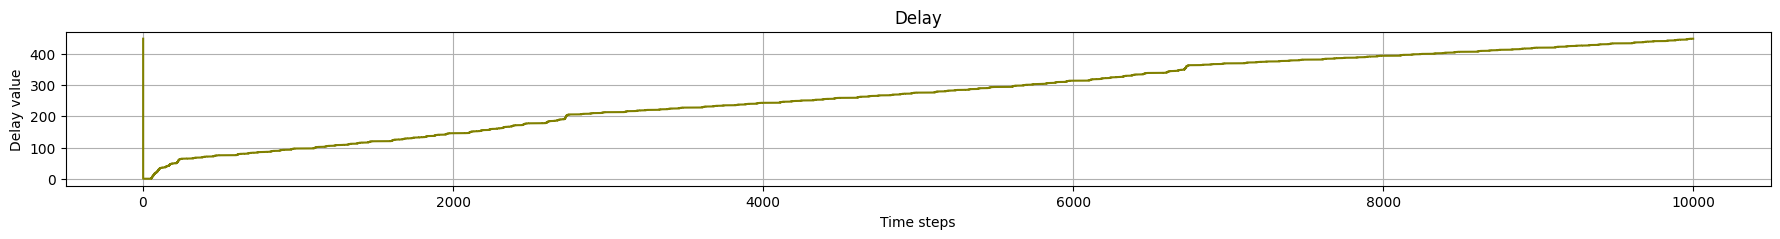

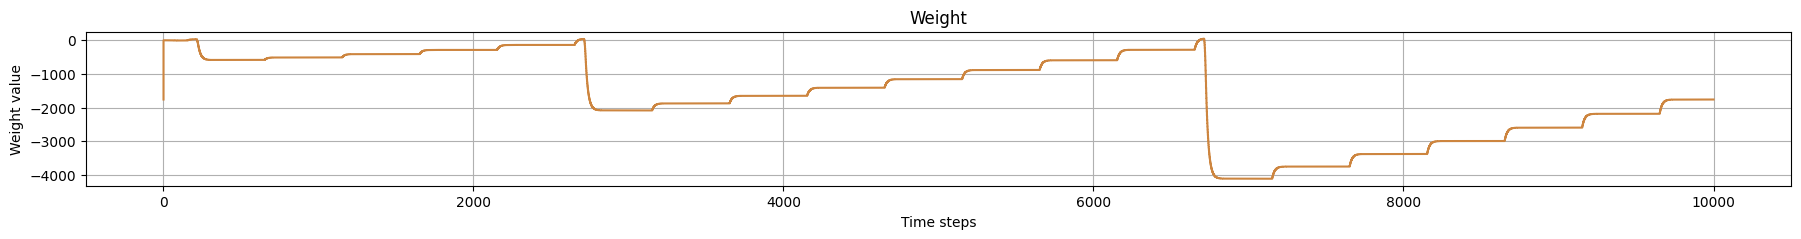

In [16]:
plot_time_series(time=time, 
                 time_series=y3_, 
                 ylabel="Trace value", 
                 title="Membrane Potential trace (y3)", 
                 figsize=(22, 2), 
                 color='royalblue')

plot_time_series(time=time, 
                 time_series=tag, 
                 ylabel="Tag value", 
                 title="Tag", 
                 figsize=(22, 2), 
                 color='darkorange')

plot_time_series(time=time, 
                 time_series=delay, 
                 ylabel="Delay value", 
                 title="Delay", 
                 figsize=(22, 2), 
                 color='olive')

plot_time_series(time=time, 
                 time_series=weights, 
                 ylabel="Weight value", 
                 title="Weight", 
                 figsize=(22, 2), 
                 color='peru')